### Summary:
In this section I create additional syntethic variables derived from information contained in the dataset. These synthetic variables might be useful for the predictive model in the next step. Also, a further examination is carried out to reveal trends and insights in the data. The dataset containing the synthetic variables is saved as a csv file for the next Part. 

In [33]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from utils import *

In [34]:
if os.path.exists('data_nyctaxi_2017_cleaned.csv'): # Check if the dataset is present on local disk and load it
    data = pd.read_csv('data_nyctaxi_2017_cleaned.csv')
else:
    print('Run Part-1 first')

In [5]:
print(len(data))
data = data.sample(frac=0.3, replace=False, random_state=1)
print(len(data))

1109528
332858


## 2.1 Creating synthetic variables:

In [35]:
# Let's give time variables the right format:
data['Pickup_dt'] = data.Pickup_dt.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['Dropoff_dt'] = data.Dropoff_dt.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['Dropoff_dt'].head()

0   2017-03-13 22:12:45
1   2017-11-26 20:50:41
2   2017-11-29 20:05:08
3   2017-03-10 19:47:35
4   2017-11-29 00:22:07
Name: Dropoff_dt, dtype: datetime64[ns]

In [36]:
# Function to run the feature engineering
def additional_variables(mydata):
    """
    This function create new variables based on present variables in the dataset adata. It creates:
    . Week: int {1,2,3,4,5}, Week a transaction was done
    . Week_day: int [0-6], day of the week a transaction was done
    . Month_day: int [0-30], day of the month a transaction was done
    . Hour: int [0-23], hour the day a transaction was done
    . Shift type: int {1=(7am to 3pm), 2=(3pm to 11pm) and 3=(11pm to 7am)}, shift of the day  
    . Speed_mph: float, speed of the trip
    . Tip_percentage: float, target variable
    . With_tip: int {0,1}, 1 = transaction with tip, 0 transction without tip
    
    input:
        adata: pandas.dataframe
    output: 
        pandas.dataframe
    """
    
    # make copy of the original dataset
    data = mydata.copy()
    
    # time variables
    print ("deriving time variables...")
    data['Week'] = np.NAN
    
    ref_week_march = dt.datetime(2017,3,1).isocalendar()[1] # first week of march in 2017
    data.loc[data.month=='March','Week'] = data[data.month=='March'].Pickup_dt.apply(lambda x:x.isocalendar()[1])-ref_week_march+1
    
    ref_week_june = dt.datetime(2017,6,1).isocalendar()[1] # first week of june in 2017
    data.loc[data.month=='June','Week'] = data[data.month=='June'].Pickup_dt.apply(lambda x:x.isocalendar()[1])-ref_week_june+1

    ref_week_nov = dt.datetime(2017,11,1).isocalendar()[1] # first week of nov in 2017
    data.loc[data.month=='Nov','Week'] = data[data.month=='Nov'].Pickup_dt.apply(lambda x:x.isocalendar()[1])-ref_week_nov+1

    data['Week_day']  = data.Pickup_dt.apply(lambda x:x.isocalendar()[2])
    data['Month_day'] = data.Pickup_dt.apply(lambda x:x.day)
    data['Hour'] = data.Pickup_dt.apply(lambda x:x.hour)
        
    # Trip duration 
    print ("deriving Trip_duration...")
    data['Trip_duration'] = (abs(data.Dropoff_dt-data.Pickup_dt).apply(lambda x:x.total_seconds()/60.))
    
    # create shift variable:  1=(7am to 3pm), 2=(3pm to 11pm) and 3=(11pm to 7am)
    data['Shift_type'] = np.NAN
    data.loc[data[(data.Hour>=7) & (data.Hour<15)].index,'Shift_type'] = 1
    data.loc[data[(data.Hour>=15) & (data.Hour<23)].index,'Shift_type'] = 2
    data.loc[data[data.Shift_type.isnull()].index,'Shift_type'] = 3
    
          
    # create variable for Speed
    print ("deriving Speed. Make sure to check for possible NaNs and Inf vals...")
    data['Speed_mph'] = data.trip_distance/(data.Trip_duration/60)
    indices_oi = data[(data.Speed_mph.isnull()) | (data.Speed_mph>240)].index
    data.loc[indices_oi,'Speed_mph'] = np.abs(np.random.normal(loc=12.9,scale=6.8,size=len(indices_oi)))
      
    # Target variables:    
    # we will create a variable tip percentage (that will be used in the model) 
    data['Tip_percentage'] = 100*data.tip_amount/data.total_amount
    
    # we also create a categoric variable 'with_tip' telling us whether the client tips or not
    
    data['With_tip'] = (data.Tip_percentage>0)*1

    return data

### We have created a number of synthetic variables that will be interesting to find trends in the data:

In [37]:
data_ext = additional_variables(data)

deriving time variables...
deriving Trip_duration...
deriving Speed. Make sure to check for possible NaNs and Inf vals...


In [7]:
print("Number of variables: ", data_ext.shape[1])

Number of variables:  29


In [32]:
data_ext.to_csv('data_nyctaxi_2017_cleaned_2_model.csv', index=True)

## 2.2 Data Summary

### The target variable we will explore is the tip as percetage of the total amount as we want the tip to be independent of the ride's cost. The figure below shows the distribution of the tip percentage. It averages ~ 16%.

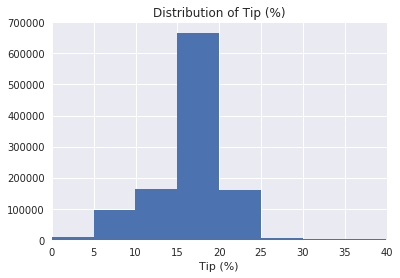

In [41]:
ax = data_ext.Tip_percentage.hist(bins = 20)
ax.set_xlabel('Tip (%)')
ax.tick_params(labelsize=10)
ax.set_title('Distribution of Tip (%)')
ax.set_xlim(0, 40)
plt.show()

### Trends in  number of taxi rides per day in the month (right) and per hour in the day (left). 
* The graph on the right shows a slight decreasing trend with time, until aaround the 28th of the month. It could be due to the fact that monthly salaries are paid around that date in most companies. The graph also shows a intra-weekly trend peaking in the middle of the week and lowering down in the weekends. This might be explained by the fact people tend to use taxis for commuting to work. 
* The graph on the left shows a clear daily trend with a strong decrease in the number of taxi rides during night time. 

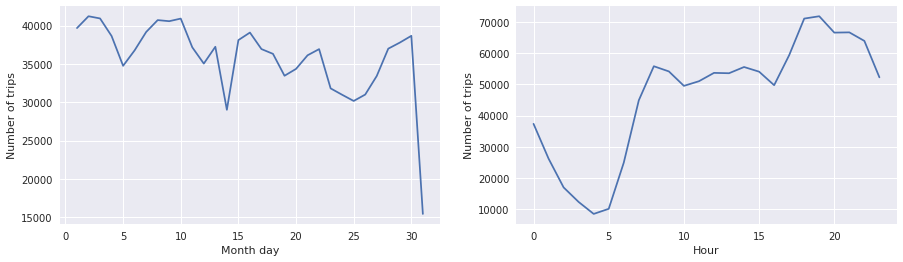

In [21]:
fig,ax = plt.subplots(1,2,figsize = (15,4)) 

ax[0] = data_ext.groupby(['Month_day']).size().plot(kind='line',ax=ax[0])
#ax[0] = data_ext.groupby(['Week_day']).size().plot(kind='bar',ax=ax[0])
ax[0].set_xlabel('Month day')
ax[0].set_ylabel('Number of trips')
ax[0].tick_params(labelsize=10)

ax[1] = data_ext.groupby(['Hour']).size().plot(kind='line',ax=ax[1])
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Number of trips')
ax[1].tick_params(labelsize=10)


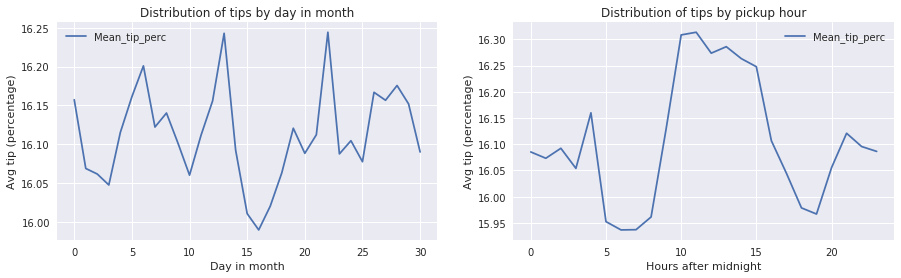

In [23]:
fig,ax = plt.subplots(1,2,figsize = (15,4)) 
table1 = data_ext.pivot_table(index='Hour', values='Tip_percentage',aggfunc=('mean')).reset_index()
table1.columns = ['Hour','Mean_tip_perc']

ax[1]=table1[['Mean_tip_perc']].plot(ax=ax[1])
ax[1].set_ylabel('Avg tip (percentage)')
ax[1].set_xlabel('Hours after midnight')
ax[1].set_title('Distribution of tips by pickup hour')
ax[1].tick_params(labelsize=10)


table2 = data_ext.pivot_table(index='Month_day', values='Tip_percentage',aggfunc=('mean')).reset_index()
table2.columns = ['Month_day','Mean_tip_perc']

ax[0]=table2[['Mean_tip_perc']].plot(kind='line',ax=ax[0])
ax[0].set_ylabel('Avg tip (percentage)')
ax[0].set_xlabel('Day in month')
ax[0].set_title('Distribution of tips by day in month')
ax[0].tick_params(labelsize=10)

* Figure shows the distribution of the average tip percentage by the day in the month (left) and by hour in the day (right). 
* There is a slight increase of the average tip over working hours (9 am- 3 pm), maybe most of these rides are related to work activities and paid by companies.

### Fare amount and tip

In [20]:
data_ext['fare_tram']= pd.cut(data_ext['fare_amount'], np.arange(0,100,10)).astype(str) 

                 conv        vol      cumvol
fare_tram_                                  
(0, 10]     16.536908  53.039851   53.039851
(10, 20]    15.601110  31.469868   84.509719
(20, 30]    15.553127   7.635950   92.145669
(30, 40]    16.017579   3.483824   95.629493
(40, 50]    15.851837   1.242240   96.871733
(50, 60]    15.732157   2.682582   99.554315
other       14.967679   0.445685  100.000000


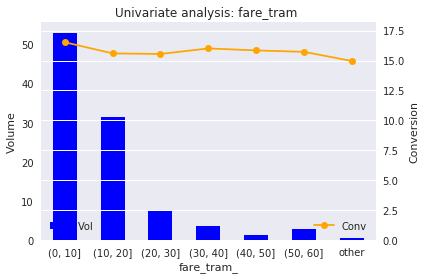

In [21]:
univariate_with_plot(data_ext,'fare_tram','Tip_percentage')

### Duration of the taxi rides and its relation with tip percentage

* Average tip duration is ~16 min with a median value of ~12 min. The sample contains very long trips (outliers) of up to 23h.
* 75\% of the taxi ride's duration is below 20 minutes
* The largest Average tip percentage occurs in trips below ten minutes

In [15]:
data_ext.Trip_duration.describe()

count    1.109528e+06
mean     1.682102e+01
std      4.950240e+01
min      0.000000e+00
25%      7.133333e+00
50%      1.181667e+01
75%      1.926667e+01
max      1.439633e+03
Name: Trip_duration, dtype: float64

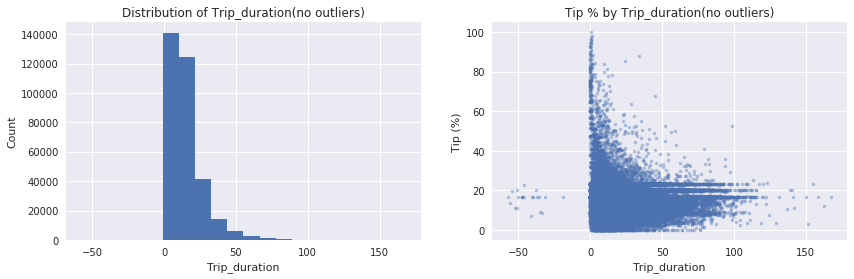

In [50]:
plot_continuous(data_ext,'Trip_duration',outlier='off')

* The  figure above shows the distribution of taxi ride's duration (right) and the average tip by trip duration on the left. Outliters have been ommited. 

In [12]:
data_ext['duration_tram']= pd.cut(data_ext['Trip_duration'], np.arange(0,100,10)).astype(str) 

                     conv        vol      cumvol
duration_tram_                                  
(0, 10]         16.680882  41.014107   41.014107
(10, 20]        15.765452  35.633170   76.647277
(20, 30]        15.588478  13.532962   90.180239
(30, 40]        15.650401   5.152461   95.332700
(40, 50]        15.727280   2.266189   97.598889
(50, 60]        15.842696   1.155627   98.754515
other           15.849785   1.245485  100.000000


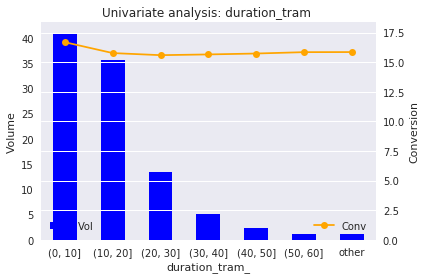

In [13]:
univariate_with_plot(data_ext,'duration_tram','Tip_percentage')

* This figure shows % number of rides per duration bin (blue bars) and the average %tip  (yellow line) per duration bin. We find that highest tips are given in the shortest rides.

### RateCodeId 

In [29]:
data_ext.groupby('RatecodeID').agg({'Tip_percentage':['mean','median']})

Tip_percentage           
                     mean     median
RatecodeID                          
1               16.127136  16.666667
2               15.783667  16.664295
3               15.334720  16.658329
4               15.328140  16.658782
5               15.321464  16.665279

It does not seem to be a significant difference

RatecodeID


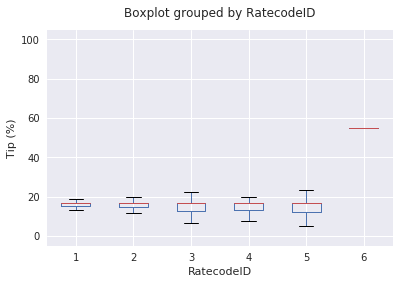

one way anova test: F_onewayResult(statistic=82.65273910208222, pvalue=4.262893992273982e-87)
Frequency of categories (%):
 1    97.131753
2     2.322609
5     0.280119
3     0.222076
4     0.043352
6     0.000090
Name: RatecodeID, dtype: float64


In [16]:
plot_categories(data_ext,'RatecodeID')